---
# Mega script
---

In [399]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from confusion_matrix import confusion_matrix
from sklearn.metrics import confusion_matrix as cf
from sklearn.feature_selection import SequentialFeatureSelector

"""
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr"
})
"""

'\nplt.rcParams.update({\n    "text.usetex": True,\n    "font.family": "cmr"\n})\n'

In [489]:
config = {
    "standardize" : True,
    "lda_reduce" : 5,
    "classifier" : "svm",
    "keep_features" : 7,
    "drop_8_18" : False,
    "direction" : "backward" 
}

In [447]:
# Load data sets
trn_data = pd.read_csv(f"../TrainingData/neodata/soltani_14d_nonoise_1200.csv")
vld_data = pd.read_csv(f"../ValidationData/neodata/soltani_14d_nonoise_1200.csv")
tst_data = pd.read_csv(f"../TestData/neodata/soltani_14d_nonoise_100.csv")

if config["drop_8_18"]:
    trn_data = trn_data[ (trn_data['target'] != 8) & (trn_data['target'] != 18) ]
    vld_data = vld_data[ (vld_data['target'] != 8) & (vld_data['target'] != 18) ]
    tst_data = tst_data[ (tst_data['target'] != 8) & (tst_data['target'] != 18) ]

# Separate into data and targets
y_trn = trn_data.pop('target')
X_trn = trn_data

y_vld = vld_data.pop('target')
X_vld = vld_data

y_tst = tst_data.pop('target')
X_tst = tst_data

----
## Standardize data

In [448]:

if config["standardize"]:
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    
    cols = X_trn.columns

    X_trn_std = standardizer.fit_transform(X_trn)
    X_vld_std = standardizer.transform(X_vld)
    X_tst_std = standardizer.transform(X_tst)

    X_trn_std = pd.DataFrame(X_trn_std,columns = cols)
    X_vld_std = pd.DataFrame(X_vld_std,columns = cols)
    X_tst_std = pd.DataFrame(X_tst_std,columns = cols)
else:
    X_trn_std = X_trn
    X_vld_std = X_vld
    X_tst_std = X_tst

----
## Classifier definitions

In [449]:
def classifier(classifier_select):
    if classifier_select == "qda":
        from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
        return QuadraticDiscriminantAnalysis()
        
    elif classifier_select == "lda":
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        return LinearDiscriminantAnalysis()
        
    elif classifier_select == "lda_self":
        import lda
        return lda.classifier(X_trn_std,y_trn)

    elif classifier_select == "svm":
        from sklearn import svm
        return svm.SVC( C=1000, decision_function_shape="ovo", gamma=.01 )

----
## Feature selection

In [451]:
def feature_selection():

    num_of_features = np.shape(X_trn.columns)[0]

    fts = X_trn_std.assign(target=y_trn).sample(frac=0.1)
    y_fts = fts.pop('target')
    X_fts = fts

    fts_vld = X_vld_std.assign(target=y_vld).sample(frac=0.1)
    y_fts_vld = fts_vld.pop('target')
    X_fts_vld = fts_vld

    summary = pd.DataFrame({'n_features':[],'score':[], 'feature_name' : [], 'direction' : []})
    for i in range(2,num_of_features):
        for j in ["forward","backward"]:
            
            bw = SequentialFeatureSelector(classifier(config["classifier"]), direction=j, n_jobs=-1, n_features_to_select=i)
            bw.fit(X_fts, y_fts)

            features = X_trn.columns[bw.get_support()]

            score_clf = classifier(config["classifier"])
            score_clf.fit(X_fts[features],y_fts)

            score = score_clf.score(X_fts_vld[features],y_fts_vld)
            summary = pd.concat([summary, pd.DataFrame({'n_features':i,'score':score,'feature_name': [X_fts.columns[bw.get_support()]], 'direction': j})], )
    
    return summary

# Caching of feature selection if classifier is unchanged
if not 'summary' in globals() or (not 'cached_classifier' in globals()):
    cached_classifier = config["classifier"]
    summary = feature_selection()
elif 'cached_classifier' in globals():
    if not cached_classifier == config["classifier"]:
        cached_classifier = config["classifier"]
        summary = feature_selection()

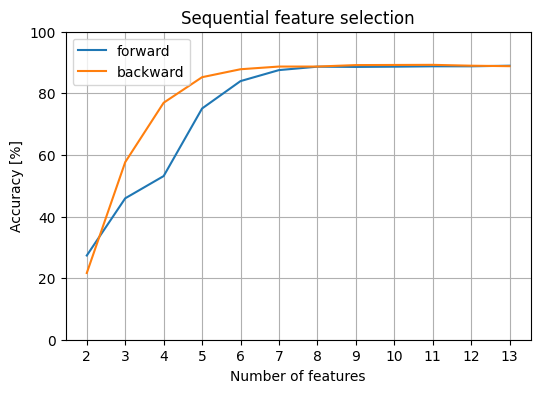

In [452]:
import matplotlib
col = matplotlib.colormaps['tab20']
colors = {'forward': col.colors[0], 'backward': col.colors[6]}

plt.figure(figsize=(6,4)) #(6,4) good size for the report
for j in ["forward","backward"]:
    plot_data = summary.loc[summary['direction'] == j]
    # print(plot_data)
    plt.plot(plot_data['n_features'],plot_data['score']*100, label = j)

plt.ylabel('Accuracy [%]')
plt.xlabel('Number of features')
plt.ylim([0,100])
plt.title('Sequential feature selection')
plt.legend()
plt.grid(True)
plt.xticks(range(2,14));

In [490]:
if config["keep_features"]:
    
    features = summary[(summary["n_features"] == config["keep_features"]) & (summary["direction"] == config["direction"])]["feature_name"][0]
    
    print(f"Keeping : { features.tolist() }")
    X_trn_drop = X_trn_std[features]
    X_vld_drop = X_vld_std[features]
    X_tst_drop = X_tst_std[features]
else:
    X_trn_drop = X_trn_std
    X_vld_drop = X_vld_std
    X_tst_drop = X_tst_std

Keeping : ['T0', 'Tc', 'Tdis', 'Tret', 'Tsuc', 'Tsup', 'CprPower']


----
## LDA dimensionality reduction

### Try all possibilities of LDA reduction

In [454]:
import lda

lda_accuracy = []
for i in range(1,len(X_trn_drop.columns)):
    
    reducer = lda.reducer(X_trn_drop,y_trn,i)

    X_trn_red = reducer.transform(X_trn_drop)
    X_vld_red = reducer.transform(X_vld_drop)
    
    clf = classifier(config["classifier"])
    clf.fit(X_trn_red,y_trn)

    lda_accuracy.append( sum(clf.predict(X_vld_red) == y_vld)/len(y_vld) )

Conditioning of Sw : 204.62
Preserving 42.37% of variance
Conditioning of Sw : 204.62
Preserving 75.2% of variance
Conditioning of Sw : 204.62
Preserving 88.52% of variance
Conditioning of Sw : 204.62
Preserving 99.47% of variance
Conditioning of Sw : 204.62
Preserving 99.77% of variance
Conditioning of Sw : 204.62
Preserving 99.96% of variance


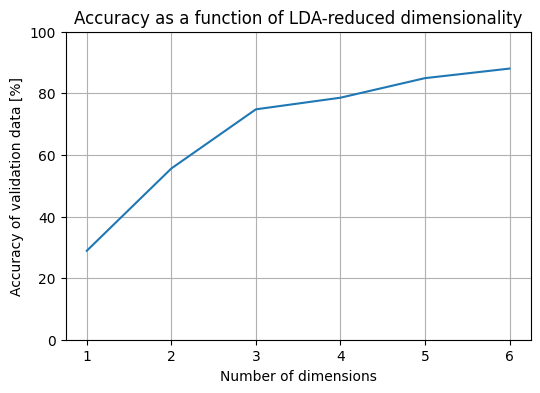

In [455]:
  
fig,axs2 = plt.subplots(figsize=(6,4))
axs2.plot(range(1,len(X_trn_drop.columns)),np.array(lda_accuracy)*100)
axs2.set_title("Accuracy as a function of LDA-reduced dimensionality")
axs2.set_xticks(range(1,len(X_trn_drop.columns)))
axs2.set_xlabel("Number of dimensions")
axs2.set_ylabel("Accuracy of validation data [%]")
axs2.set_ylim([0,100])
axs2.grid()

In [491]:
if config["lda_reduce"] != False:
    import lda
    reducer = lda.reducer(X_trn_drop,y_trn,config["lda_reduce"])

    X_trn_red = reducer.transform(X_trn_drop)
    X_tst_red = reducer.transform(X_tst_drop)
    X_vld_red = reducer.transform(X_vld_drop)
else:
    X_trn_red = X_trn_drop
    X_tst_red = X_tst_drop
    X_vld_red = X_vld_drop

Conditioning of Sw : 204.62
Preserving 99.77% of variance


----
# Classification on LDA-reduced data

In [492]:
# Define naming strings
str_feature = f"FS{x}-" if (x:=config["keep_features"]) else ""
str_lda = f"LDA{x}-" if (x:=config["lda_reduce"]) else ""
str_classifier = f"{x}" if (x:=config["classifier"].upper()) else ""

In [493]:
clf = classifier(config["classifier"])
clf.fit(X_trn_red,y_trn)

SVC(C=1000, decision_function_shape='ovo', gamma=0.01)

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'FS7-LDA5-SVM of validation set : Accuracy 84.929%'}, xlabel='Predicted class', ylabel='True class'>)

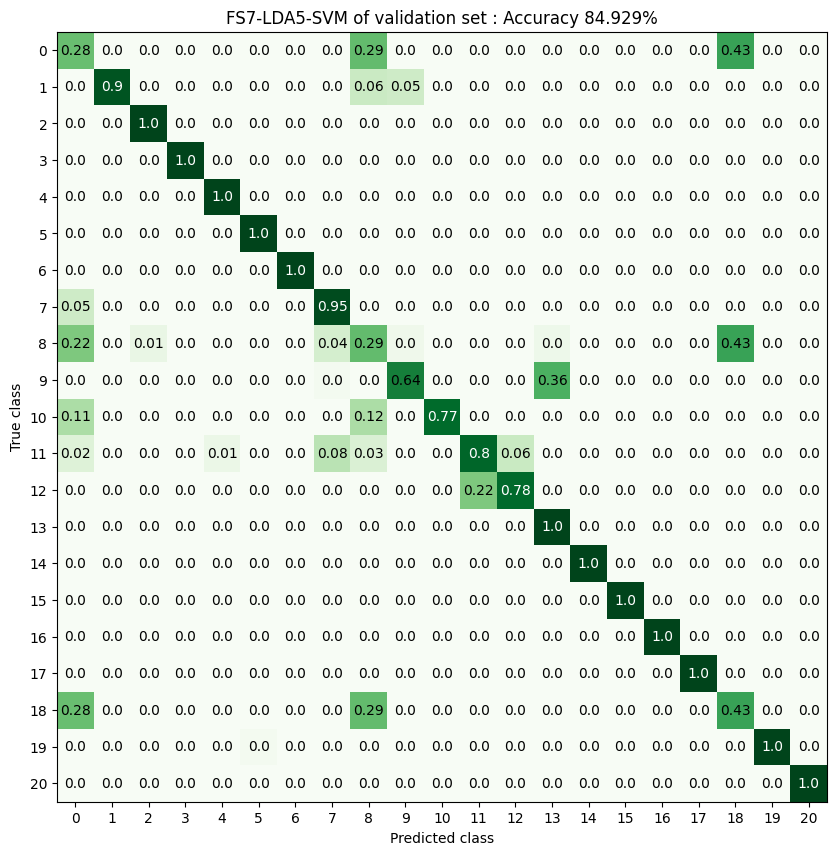

In [494]:
# Make predictions for the training set
y_hat_vld = clf.predict(X_vld_red)

#plot the confusion matrix
conf_matrix_vld = cf(y_vld,y_hat_vld)
confusion_matrix(
    conf_matrix_vld,
    title = f'{str_feature}{str_lda}{str_classifier} of validation set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-validation.pdf')

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'FS7-LDA5-SVM of test set : Accuracy 90.476%'}, xlabel='Predicted class', ylabel='True class'>)

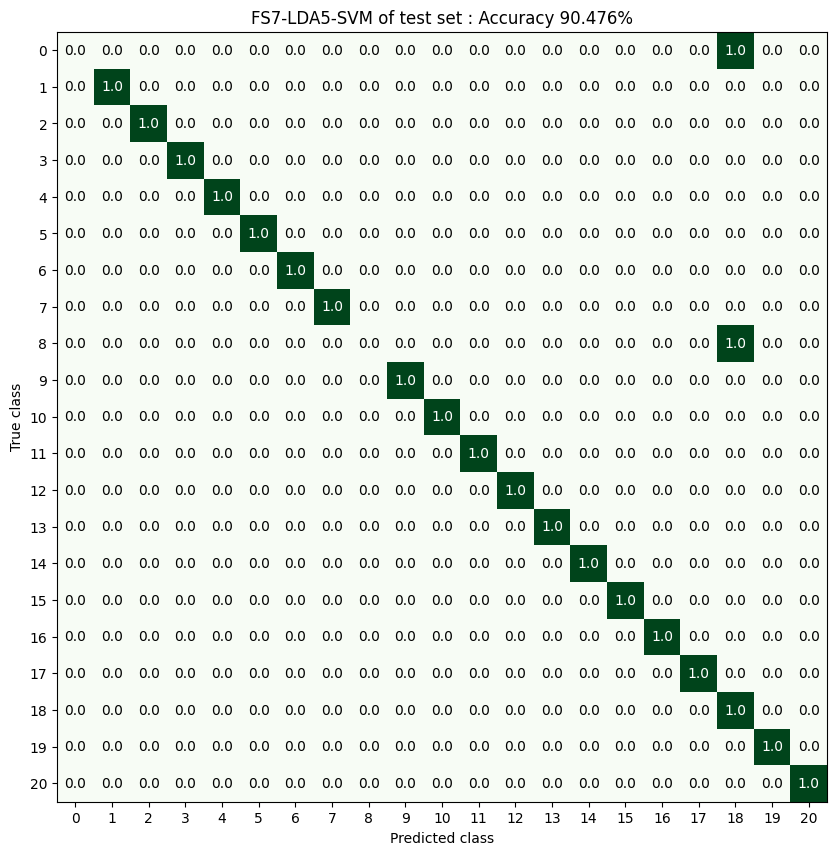

In [495]:
# Make predictions for the training set
y_hat_tst = clf.predict(X_tst_red)

#plot the confusion matrix
conf_matrix_tst = cf(y_tst,y_hat_tst)
confusion_matrix(
    conf_matrix_tst,
    title = f'{str_feature}{str_lda}{str_classifier} of test set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-test.pdf')

----
# Classification of feature selected data

In [496]:
# Define naming strings
str_feature = f"FS{x}-" if (x:=config["keep_features"]) else ""
str_classifier = f"{x}" if (x:=config["classifier"].upper()) else ""

In [497]:
clf = classifier(config["classifier"])
clf.fit(X_trn_drop,y_trn)

SVC(C=1000, decision_function_shape='ovo', gamma=0.01)

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'FS7-SVM of validation set : Accuracy 90.532%'}, xlabel='Predicted class', ylabel='True class'>)

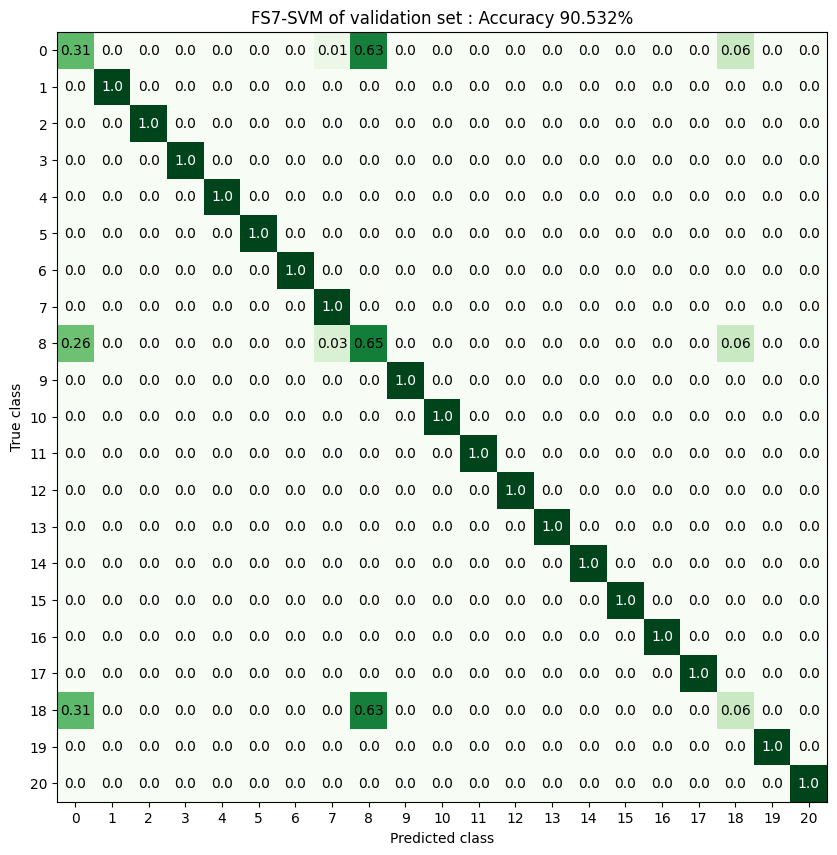

In [498]:
# Make predictions for the training set
y_hat_vld = clf.predict(X_vld_drop)

#plot the confusion matrix
conf_matrix_vld = cf(y_vld,y_hat_vld)
confusion_matrix(
    conf_matrix_vld,
    title = f'{str_feature}{str_classifier} of validation set',
    save_fig_name = f'{str_feature}{str_classifier}-validation.pdf')

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'FS7-SVM of test set : Accuracy 90.476%'}, xlabel='Predicted class', ylabel='True class'>)

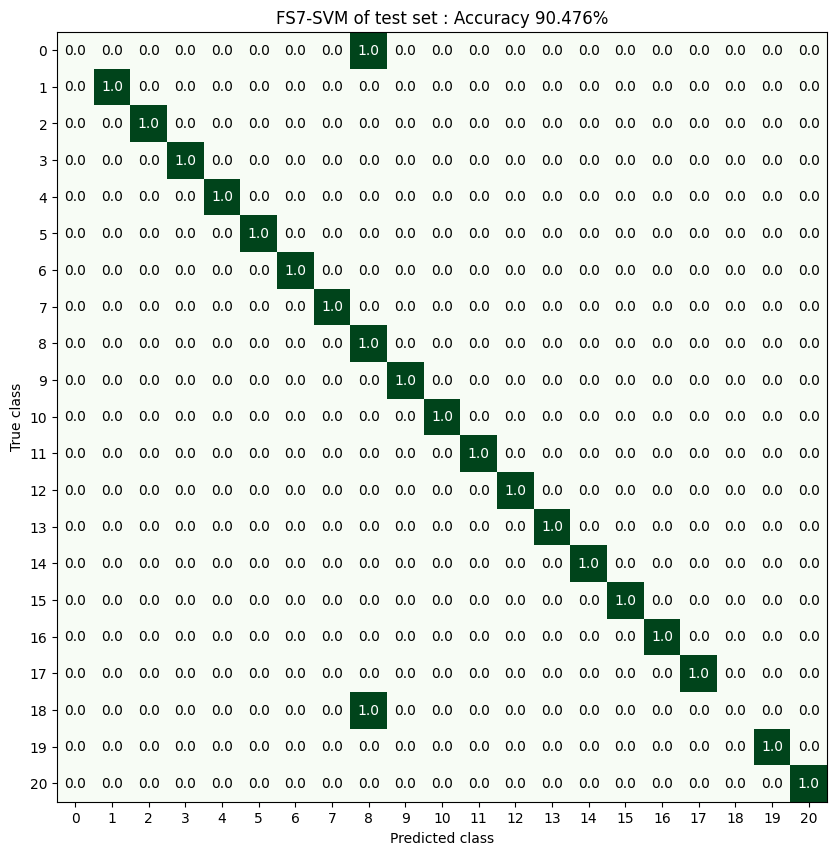

In [499]:
# Make predictions for the training set
y_hat_tst = clf.predict(X_tst_drop)

#plot the confusion matrix
conf_matrix_tst = cf(y_tst,y_hat_tst)
confusion_matrix(
    conf_matrix_tst,
    title = f'{str_feature}{str_classifier} of test set',
    save_fig_name = f'{str_feature}{str_classifier}-test.pdf')

----
# Extra plot

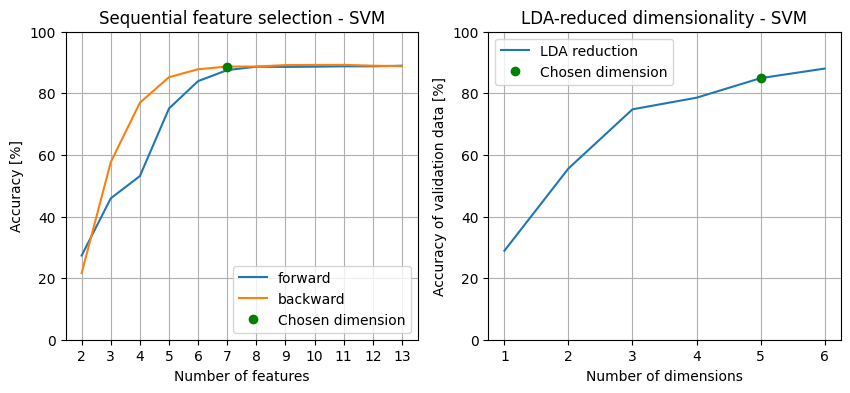

In [500]:
fig,(axs1,axs2) = plt.subplots(1,2,figsize=(10,4))

# Plot feature selection
for j in ["forward","backward"]:
    plot_data = summary.loc[summary['direction'] == j]
    axs1.plot(plot_data['n_features'],plot_data['score']*100, label = j)

axs1.plot(plot_data['n_features'][plot_data['n_features'] == config["keep_features"]],plot_data['score'][plot_data['n_features'] == config["keep_features"]]*100,'o',c="green",label = "Chosen dimension")
axs1.set_ylabel('Accuracy [%]')
axs1.set_xlabel('Number of features')
axs1.set_ylim([0,100])
axs1.set_title(f'Sequential feature selection - {config["classifier"].upper()}')
axs1.legend()
axs1.grid(True)
axs1.set_xticks(range(2,14));

# Plot LDA reduction
axs2.plot(range(1,len(X_trn_drop.columns)),np.array(lda_accuracy)*100,label = "LDA reduction")
axs2.plot(config["lda_reduce"],lda_accuracy[config["lda_reduce"]-1]*100,'o',c="green",label = "Chosen dimension")
axs2.set_title(f'LDA-reduced dimensionality - {config["classifier"].upper()}')
axs2.set_xticks(range(1,len(X_trn_drop.columns)))
axs2.set_xlabel("Number of dimensions")
axs2.set_ylabel("Accuracy of validation data [%]")
axs2.set_ylim([0,100])
axs2.legend()
axs2.grid()